In [1]:
#  STEP 1: IMPORT ALL DEPENDENCIES
import pandas as pd
import numpy as np
import re
import nltk
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
# Load datasets
df_twitter = pd.read_csv('/content/dataset6.csv')
df_reddit = pd.read_csv('/content/dataset6.1.csv')
df_stock = pd.read_csv('/content/dataset4.csv')

# Inspect columns
print("Twitter columns:", df_twitter.columns.tolist())
print("Reddit columns:", df_reddit.columns.tolist())
print("Stock columns:", df_stock.columns.tolist())

# Standardize to ['text', 'sentiment']
def standardize(df, text_col, sentiment_col):
    return df[[text_col, sentiment_col]].rename(columns={text_col: 'text', sentiment_col: 'sentiment'})

df_twitter = standardize(df_twitter, 'clean_text', 'category')
df_reddit = standardize(df_reddit, 'clean_comment', 'category')

# Note: Stock tweets don’t have sentiment labels, so skip for now or label later
# You can use Vader/TextBlob to label them in a later step
df_all = pd.concat([df_twitter, df_reddit], ignore_index=True)
df_all.dropna(inplace=True)
df_all['sentiment'] = df_all['sentiment'].astype(int)

# Preview
df_all.head()


Twitter columns: ['clean_text', 'category']
Reddit columns: ['clean_comment', 'category']
Stock columns: ['Date', 'Tweet', 'Stock Name', 'Company Name']


,text,sentiment
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [3]:
# Install vaderSentiment
!pip install vaderSentiment

# Import necessary libraries
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.1 MB/s eta 0:00:00


In [4]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment (positive, negative, neutral)
def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    compound_score = score['compound']
    if compound_score >= 0.05:
        return 1  # Positive sentiment
    elif compound_score <= -0.05:
        return -1  # Negative sentiment
    else:
        return 0  # Neutral sentiment

# Apply sentiment analysis to stock dataset
df_stock['sentiment'] = df_stock['Tweet'].apply(get_sentiment)

# Check the result
print(df_stock[['Tweet', 'sentiment']].head())


                                               Tweet  sentiment
0  Mainstream media has done an amazing job at br...          1
1  Tesla delivery estimates are at around 364k fr...          0
2  3/ Even if I include 63.0M unvested RSUs as of...          1
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...         -1
4  @RealDanODowd @Tesla Stop trying to kill kids,...         -1


In [5]:
# Standardize stock data (like you did with Twitter and Reddit)
df_stock = standardize(df_stock, 'Tweet', 'sentiment')

# Merge with Twitter and Reddit data
df_all = pd.concat([df_twitter, df_reddit, df_stock], ignore_index=True)

# Clean data (drop any remaining NaNs)
df_all.dropna(inplace=True)

# Preview the combined data
print(df_all.head())


                                                text  sentiment
0  when modi promised “minimum government maximum...       -1.0
1  talk all the nonsense and continue all the dra...        0.0
2  what did just say vote for modi  welcome bjp t...        1.0
3  asking his supporters prefix chowkidar their n...        1.0
4  answer who among these the most powerful world...        1.0


In [6]:

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Preprocessing function
def preprocess_text(text):
    # Lowercase text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove mentions and hashtags (optional)
    text = re.sub(r'@\w+|#\w+', '', text)
    # Remove non-alphabetic characters (optional)
    text = re.sub(r'[^a-z\s]', '', text)
    return text

# Apply preprocessing to the text column
df_all['text'] = df_all['text'].apply(preprocess_text)

# Tokenize the text
tokenizer = Tokenizer(num_words=10000)  # Limit to top 10,000 words
tokenizer.fit_on_texts(df_all['text'])
sequences = tokenizer.texts_to_sequences(df_all['text'])

# Pad sequences to ensure uniform input length for LSTM
X = pad_sequences(sequences, maxlen=100)  # Pad to 100 words per sequence

# Prepare sentiment labels
y = df_all['sentiment']

print("Preprocessed Data:", X.shape, y.shape)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Preprocessed Data: (280911, 100) (280911,)


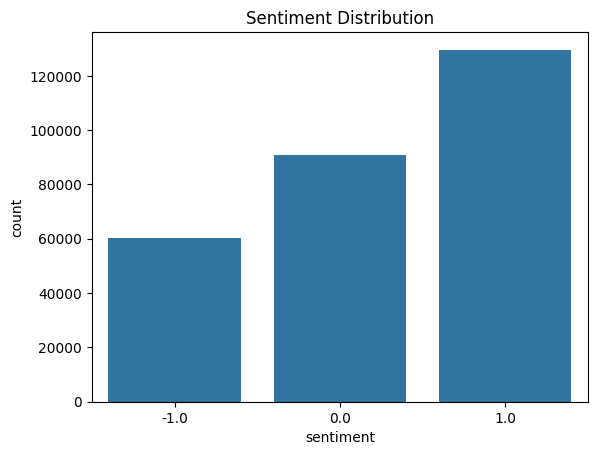

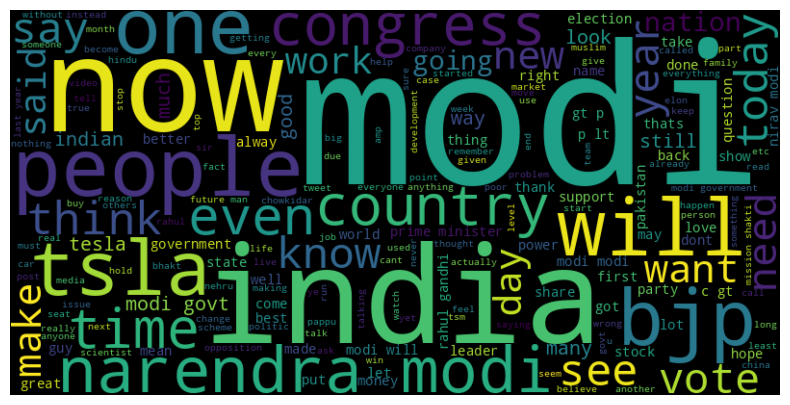

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
sns.countplot(x='sentiment', data=df_all)
plt.title('Sentiment Distribution')
plt.show()

# Check the word cloud for a quick glance at the most common words
from wordcloud import WordCloud

# Generate word cloud from the cleaned text
wordcloud = WordCloud(width=800, height=400).generate(' '.join(df_all['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [8]:
import plotly.express as px

# Sentiment Distribution Plot
sentiment_counts = df_all['sentiment'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment', 'count']  # Rename columns for clarity

fig = px.bar(sentiment_counts,
             x='sentiment', y='count',
             labels={'sentiment': 'Sentiment', 'count': 'Count'},
             title='Sentiment Distribution')
fig.show()


In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout

# Ensure the labels are properly mapped
y = df_all['sentiment'].map({-1: 0, 0: 1, 1: 2})

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=128, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 classes: 0 (negative), 1 (neutral), 2 (positive)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X, y, epochs=5, batch_size=64, validation_split=0.2)



Epoch 1/5
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 1182s 334ms/step - accuracy: 0.8180 - loss: 0.4622 - val_accuracy: 0.6714 - val_loss: 0.8270
Epoch 2/5
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 1175s 335ms/step - accuracy: 0.9381 - loss: 0.1809 - val_accuracy: 0.7591 - val_loss: 0.6934
Epoch 3/5
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 1219s 334ms/step - accuracy: 0.9584 - loss: 0.1338 - val_accuracy: 0.7961 - val_loss: 0.6191
Epoch 4/5
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 1223s 334ms/step - accuracy: 0.9680 - loss: 0.1064 - val_accuracy: 0.7935 - val_loss: 0.6447
Epoch 5/5
3512/3512 ━━━━━━━━━━━━━━━━━━━━ 1219s 333ms/step - accuracy: 0.9744 - loss: 0.0870 - val_accuracy: 0.7974 - val_loss: 0.7148


In [10]:
# Save the model
model.save('/content/sentiment_lstm_model.h5')


In [11]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X, y, verbose=1)
print(f'Loss: {loss}, Accuracy: {accuracy}')


8779/8779 ━━━━━━━━━━━━━━━━━━━━ 517s 59ms/step - accuracy: 0.9825 - loss: 0.0625
Loss: 0.19479702413082123, Accuracy: 0.9446088075637817


In [12]:
# Plot training & validation accuracy values
fig_accuracy = px.line(x=history.epoch, y=history.history['accuracy'],
                       title="Model Accuracy", labels={'x': 'Epoch', 'y': 'Accuracy'})
fig_accuracy.add_scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='Val Accuracy')
fig_accuracy.show()

# Plot training & validation loss values
fig_loss = px.line(x=history.epoch, y=history.history['loss'],
                   title="Model Loss", labels={'x': 'Epoch', 'y': 'Loss'})
fig_loss.add_scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Val Loss')
fig_loss.show()
